# Introduction to Education and Outreach OpenData with python

In this notebook we demonstrate basic data handling of the Education & Outreach (E&O) Open Data using uproot and Awkward Array. It provides a brief introduction to the content and structure of the Open Data files and shows practical examples of reading data, plotting distributions, and creating new variables from existing branches.
Before we work with the data, we will proceed with the usual import of the atlasopenmagic package, environment initialization, and import of a handful of helpful packages for working with the open data and drawing histograms.


In [1]:
# First we install atlasopenmagic into our SWAN environment
# Notice that we need --user to avoid trying to install the package in a
# read-only file system This is a problem unique to SWAN; on binder or colab you
# won't need --user, but it doesn't hurt
%pip install --user atlasopenmagic

In [2]:
from atlasopenmagic import install_from_environment

In [3]:
install_from_environment()

Installing packages: ['aiohttp>=3.9.5', 'atlasopenmagic>=1.2.0', 'awkward>=2.6.7', 'awkward-pandas>=2023.8.0', 'coffea~=0.7.0', 'fsspec>=2025.7.0', 'hist>=2.8.0', 'ipykernel>=6.29.5', 'jupyter>=1.0.0', 'lmfit>=1.3.2', 'matplotlib>=3.9.1', 'metakernel>=0.30.2', 'notebook<7', 'numpy>=1.26.4', 'pandas>=2.2.2', 'papermill>=2.6.0', 'pip>=24.2', 'scikit-learn>=1.5.1', 'uproot>=5.3.10', 'uproot3>=3.14.4', 'fsspec-xrootd>=0.5.1', 'jupyterlab_latex~=3.1.0', 'vector>=1.4.1']
Installation complete. You may need to restart your Python environment for changes to take effect.


In [4]:
# Now we have to do a little bit of work to make sure that atlasopenmagic is
# available in our python path This is because SWAN by default does not include
# the local package installation area in the PYTHONPATH Again, this is not
# necessary on binder or colab - there you can remove these lines if you like,
# though they don't do any harm
import sys
import os
sys.path += [ f'{os.environ["HOME"]}/.local/lib/python{sys.version_info.major}.{sys.version_info.minor}/site-packages' ]

# Now we can safely import atlasopenmagic
import atlasopenmagic as atom

In [5]:
import numpy as np # for numerical calculations such as histogramming
import matplotlib.pyplot as plt # for plotting
import matplotlib_inline # to edit the inline plot format
#matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg') # to make plots in pdf (vector) format
from matplotlib.ticker import AutoMinorLocator # for minor ticks
import uproot # for reading .root files
import awkward as ak # to represent nested data in columnar format
import vector # for 4-momentum calculations
import time # for printing time stamps
import requests # for file gathering, if needed

## Load the data sets

We start by loading the data and one MC simulation from the O&E Open Data release. We study events with two Z bosons, each decaying to an oppositely charged lepton pair ($e⁺e⁻$ or $\mu⁺\mu⁻$). To simplify the notebook and cut down the event count, we apply a skim requiring at least four leptons.

In [6]:
# And let's use the latest release of Open Data for Outreach and Education
atom.set_release('2025e-13tev-beta')

In [7]:
# We will use a skim (pre-selection) of the data so that we start from events
# with at least four leptons (electrons/muon)
skim = '4lep'
# And now we can get the files we want; note that we use "cache=True" to copy
# the files locally rather than streaming them
defs = {
    r'Data':{'dids':['data']},
    r'ZZ to 4L':{'dids': [700600], 'color': "#6b59d3" }, # purple
}

samples   = atom.build_dataset(defs, skim=skim, protocol='https', cache=True)

In [8]:
# Let's look at the samples
samples

{'Data': {'list': ['simplecache::https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_4lep_data15_periodD.4lep.root',
   'simplecache::https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_4lep_data15_periodE.4lep.root',
   'simplecache::https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_4lep_data15_periodF.4lep.root',
   'simplecache::https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_4lep_data15_periodG.4lep.root',
   'simplecache::https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_4lep_data15_periodH.4lep.root',
   'simplecache::https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_4lep_data15_periodJ.4lep.root',
   'simplecache::https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_4lep_data16_periodA.4lep.root',
   'simplecache::https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_4lep_data16_periodB.4lep

This notebook will show an example on how one can read all of the ROOT files available in the 13 TeV ATLAS Open Data release, select the events one is interested in (here we will focus on events with exactly four leptons), create some histograms and write files to hdf5 for later use in e.g. machine learning. The notebook uses the Awkward Array data structures. This can be thought of as equivalent to Numpy for ragged data.

## Fetching the files and looking at the content

In this part we look more closely at the content of the E&O Open Data. We start by reading in one background ($ZZ\to4l$) and one data file (periodD from 2015). We are using [uproot](https://uproot.readthedocs.io/en/stable/index.html) to read the files and will use [awkward arrays](https://awkward-array.org/doc/2.6/index.html) to handle the data.

In [9]:
# We open an MC data file with simulated diboson events (data set ID 700600)
background_diboson_path = samples['ZZ to 4L']["list"][0]
# Accessing the file from the online database
tree_bkg = uproot.open(background_diboson_path + ":analysis")
# We open a data file from period D in 2015 (first entry in the list)
data_path = samples['Data']["list"][0]
# Accessing the file from the online database
tree_data = uproot.open(data_path + ":analysis")

We start by looking at the list of all the variables that are in the input files. The content, in terms of available variables/branches, is identical in data and MC.

In [10]:
print("%-30s %-50s"%("Variable Name","Size/dim/type"))
for var in sorted(tree_bkg.keys()):
    print("%-30s %-50s"%(var,tree_bkg[var].array().type))

Variable Name                  Size/dim/type                                     
ScaleFactor_BTAG               11458 * float32                                   
ScaleFactor_DiTauTRIGGER       11458 * float32                                   
ScaleFactor_ELE                11458 * float32                                   
ScaleFactor_ElTRIGGER          11458 * float32                                   
ScaleFactor_FTAG               11458 * float32                                   
ScaleFactor_JVT                11458 * float32                                   
ScaleFactor_LepTRIGGER         11458 * float32                                   
ScaleFactor_MLTRIGGER          11458 * float32                                   
ScaleFactor_MUON               11458 * float32                                   
ScaleFactor_MuTRIGGER          11458 * float32                                   
ScaleFactor_PHOTON             11458 * float32                                   
ScaleFactor_PILE

The first two columns show the variable name and number of entries (events) in the file (is the same for all the variables). The `*` means that the variable has only one entry per event (i.e. a variable) while `* var` means that the variable is a vector with varying length per event (*ragged*). If just a number (e.g. `4`) is shown it means a vector with the same length (4) for all the events (but this is not the case for any of the vectors in the E&O Open Data). The last column indicates the datatype of the variable.

We start by looking at the information about the leptons, counting the total number of events, the number of leptons in each even, the total number of leptons in all events and the average number of leptons (which we assume will be close to four since this is the requirement of the skim we loaded above).

In [11]:
lepton_pt = tree_bkg['lep_pt'].array()
# Counting...
print("Number of rows = ",len(lepton_pt))
print("Number of lepton in each row = ", ak.count(lepton_pt, axis=1))
print("Total number of leptons = ", ak.count(lepton_pt, axis=0))
print("Average leptons per event (multiplicity) = ",ak.count(lepton_pt, axis=None)/len(lepton_pt))

Number of rows =  11458
Number of lepton in each row =  [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..., 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
Total number of leptons =  [11458, 11458, 11458, 11458, 198, 9]
Average leptons per event (multiplicity) =  4.018065980101239


The content, in terms of available branches, is identical in data and simulation. But some variables might be empty or have standardized values in data. E.g.
*   Truth collections are all empty in data
*   All scale factors are 1 in data

Let's look at the

In [12]:
# Truth electron pT in data for the first four events (empty)
tree_data['truth_elec_pt'].array()[:4]

<Array [[], [], [], []] type='4 * var * float32'>

In [13]:
# Truth electron pT in MC for the first four events (filled!)
tree_bkg['truth_elec_pt'].array()[:4]

<Array [[44.5, 28.6, 50.8, 19.6], ..., [20.4, ...]] type='4 * var * float32'>

## Visual inspection of variables

We will now show how one can quickly look at the distribution of the variables for all the events.

First we will see how to make a plot of the distribution of a single variable per event (i.e. the scale factor for muons).

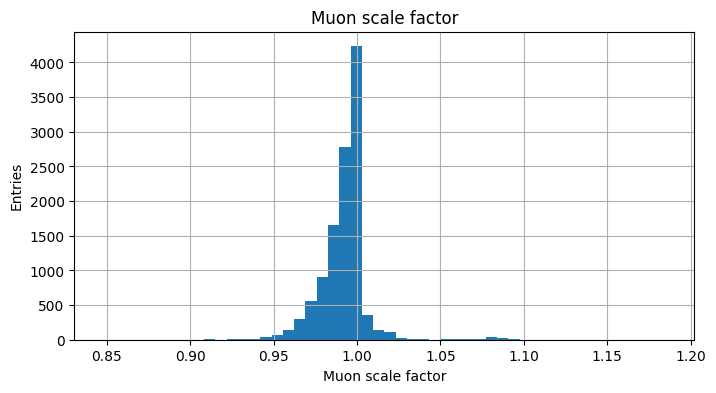

In [14]:
# Retrieve the array of the variable of interest
data = tree_bkg['ScaleFactor_MUON'].array()

# Create a simple plot
plt.figure(figsize=(8, 4))
plt.hist(data, bins=50)
plt.title('Muon scale factor')
plt.xlabel('Muon scale factor')
plt.ylabel('Entries')
plt.grid()
plt.show()

We will now in stead plot the distribution of a variable which is a vector for every event (i.e. the pT of the leptons). As we observed above most of the events have four leptons, but some will have more. We will just plot all of the leptons in all events. To do this we need to *flatten* the array.

If we look at the array of the lepton pT it is an array of arrays (nested), where the first dimension goes over events (`axis=0`) and the second over leptons (`axis=1`).

In [15]:
# Dump the lepton pT for all events as an array of arrays
tree_bkg['lep_pt'].array()

<Array [[43.8, 33.6, 31.2, 21.6], ..., [120, ...]] type='11458 * var * float32'>

Awkward array has a function for flattening the above array ([ak.flatten](https://awkward-array.org/doc/2.6/reference/generated/ak.flatten.html#ak.flatten)), removing the double nesting.

In [16]:
# Flattening the array for plotting (compare it with the output above)
ak.flatten(tree_bkg['lep_pt'].array())

<Array [43.8, 33.6, 31.2, 21.6, ..., 53.8, 31.3, 35.6] type='46039 * float32'>

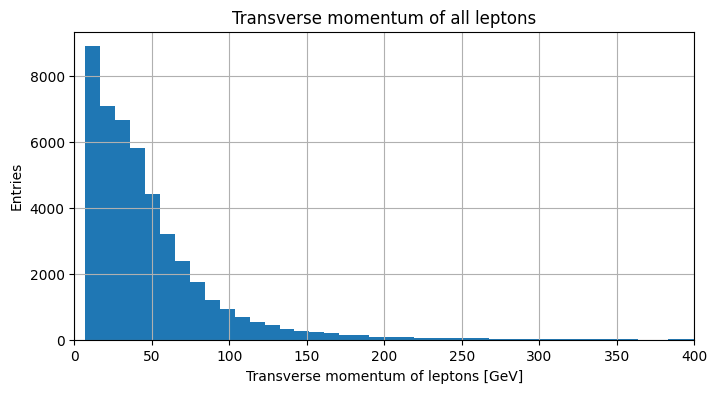

In [17]:
# Flatten to prepare for plotting
data = ak.flatten(tree_bkg['lep_pt'].array())

# Create a simple plot (identical to above)
plt.figure(figsize=(8, 4))
plt.hist(data, bins=100)
plt.title('Transverse momentum of all leptons')
plt.xlabel('Transverse momentum of leptons [GeV]')
plt.ylabel('Entries')
plt.xlim(0, 400)
plt.grid()
plt.show()

## Iterating over all event and creating new variables

In the final example we compute the per-event scale factor needed to normalize the simulation to the target integrated luminosity ($36.1~\text{fb}^{-1}$) — a necessary step when comparing data and Monte Carlo. The normalization uses the cross section of the process (`xsec`), k-factors (`kfac`), genrator filter efficiencies (`filteff`) and event weights (`mcWeight`), and the sum of generator weights (`sum_of_weights`).

However, deriving and validating all ingredients is beyond the scope of this tutorial. Instead, we will simply demonstrate how to loop over events in a file, compute a new variable from existing ones, and plot the result.

To do this efficiently with uproot, iterate over events using uproot.iterate (see the [documentation](https://uproot.readthedocs.io/en/stable/uproot.models.TBranch.Model_TBranchElement_v10.html#iterate)). The iterator yields chunks of events rather than the entire file at once. You may need to adjust the chunk size to fit your available memory — by default uproot limits each chunk to approximately 100 MB of memory, but you can override this if you have more RAM or want smaller chunks.

In [18]:
sample_data = []
# cross section is in picobarn, need to convert
# the total integrated luminosity of 36.1 inverse
# femtobarn to similar unit
lumi = 36.1*1000
# Define the variables we want to read.
variables = ["xsec","kfac","filteff","mcWeight","sum_of_weights","lep_pt"]
# Iterate over all the entries in the TTree. If no list is specified all branches are loaded!
# It iterates over the entrien in chunk. Default is to limit the memory to 100MB
for data in tree_bkg.iterate(variables,library="ak"):
  # Calculate the weight and add it as a new variable
  data["totalWeight"] = (lumi*data["xsec"]*data["kfac"]*data["filteff"]*data["mcWeight"])/data["sum_of_weights"]
  # Append this chunk of events to the final output
  sample_data.append(data)
# turns sample_data back into an awkward array
background_diboson = ak.concatenate(sample_data)

We now have a new Awkward Array that contains the original selected variables plus the computed `totalWeight`. To plot the transverse-momentum ($p_T$​) distribution of leptons both with and without event weights, we first flatten the lepton $p_T$​ array so it becomes a 1D array of all leptons. To match dimensions between this flattened $p_T$ array and the weight vector, we expand the per-event weights so that every lepton from the same event receives that event’s weight. Once the shapes match, applying the weights when histogramming with Matplotlib is straightforward.

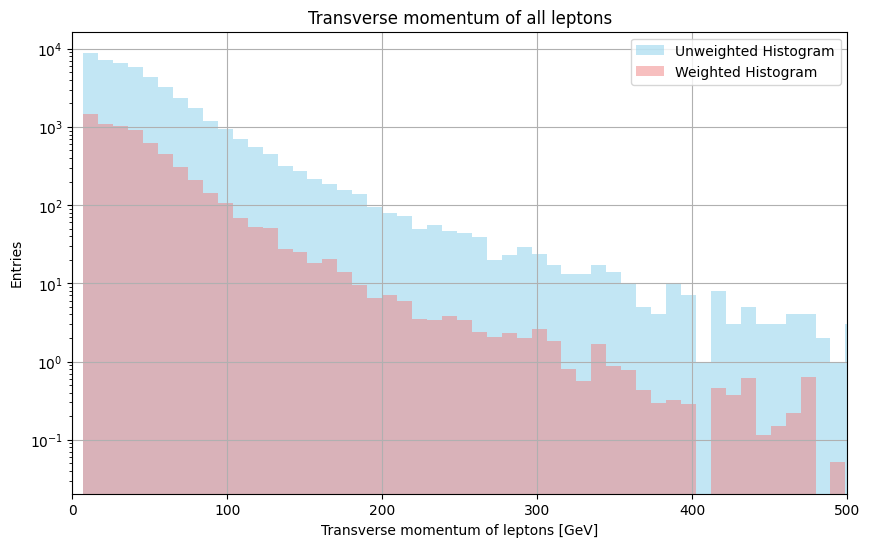

<Figure size 800x400 with 0 Axes>

In [19]:
mc_weights = ak.to_numpy(background_diboson["totalWeight"])
data = background_diboson['lep_pt']

# Expand event_weights to match the flattened data
# This broadcasts the event weight to all elements within that event's list
expanded_weights = ak.flatten(mc_weights * ak.ones_like(data))

# Flatten the data itself
flattened_data = ak.flatten(data)

fig, ax = plt.subplots(figsize=(10, 6))

# Create a simple plot
plt.figure(figsize=(8, 4))
ax.hist(flattened_data, bins=100,alpha=0.5, label='Unweighted Histogram', color='skyblue')
ax.hist(flattened_data, weights=expanded_weights, bins=100, alpha=0.5, label='Weighted Histogram', color='lightcoral')
ax.set_title('Transverse momentum of all leptons')
ax.set_xlabel('Transverse momentum of leptons [GeV]')
ax.set_ylabel('Entries')
ax.set_xlim(0, 500)
ax.set_yscale('log')
ax.grid()
ax.legend()

Well done — you’ve acquired the essential tools to proceed to a full E&O Open Data analysis. From here you can expand the workflow with selections, new variables, systematic studies, and detailed data/MC comparisons.

